In [1]:
import numpy as np
import torch
import torch.autograd as autograd
import torch.nn.functional as F
import torch.distributions as TD

import warnings
warnings.filterwarnings('ignore')

# dgm_utils
from seminar6_utils import visualize_2d_map, manual_zero_grad

# Demystifying jacobian computation

<center><img src="pics/autograd_grad1.png" width=600 /></center>

<center><img src="pics/autograd_grad2.png" width=600 /></center>

In [2]:
def batch_jacobian(input, output, create_graph=True, retain_graph=True):
    '''
    :Parameters:
    input : tensor (bs, D)
    output: tensor (bs, d) , NN(input)
    :Returns:
    gradient of output w.r.t. input (in batch manner), shape (bs, d, D)
    '''
    s_output = torch.sum(output, dim=0) # (d,)
    batched_grad_outputs = torch.eye(s_output.size(0)).to(output) #(d, d)
    grad = autograd.grad(
        outputs=s_output, inputs=input,
        grad_outputs=batched_grad_outputs,
        create_graph=create_graph, 
        retain_graph=retain_graph,
        only_inputs=True,
        is_grads_batched=True
    ) # (d, bs, D)
    return grad[0].permute(1, 0, 2)

Recall the planar flow

In [3]:
w = torch.tensor([5., 0.])
u = torch.tensor([1., 0.])
b = torch.tensor(0.)

def h(x):
    return torch.tanh(x)

def f(x, w=w, u=u, b=b):
    adj = h(x @ w + b)
    return x + torch.kron(adj.unsqueeze(-1), u)

In [4]:
p_A = TD.Normal(torch.tensor([0., 0]), torch.tensor([1., 1.]))

Recall how does planar flow transformation look like

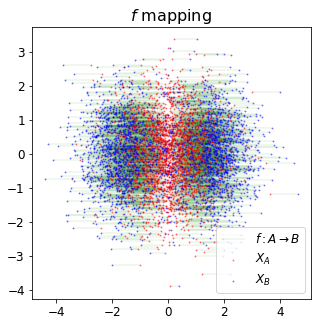

In [5]:
X_A = p_A.sample((3000,))
X_B = f(X_A)
visualize_2d_map(
    X_A, X_B, '$f$ mapping', 
    data_label=r'$X_A$', 
    mapped_data_label=r'$X_B$', 
    map_label=r'$f: A \rightarrow B$')

Let's take a look at the jacobian $\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_A}$

In [6]:
p_A = TD.Normal(torch.tensor([0., 0]), torch.tensor([1., 1.]))
X_A = p_A.sample((5,)) # (5, 2)

In [7]:
X_A = X_A.requires_grad_()
X_B = f(X_A) # (5, 2)
batch_jacobian(X_A, X_B)

tensor([[[1.0001, 0.0000],
         [0.0000, 1.0000]],

        [[1.0000, 0.0000],
         [0.0000, 1.0000]],

        [[1.0000, 0.0000],
         [0.0000, 1.0000]],

        [[4.1873, 0.0000],
         [0.0000, 1.0000]],

        [[1.4562, 0.0000],
         [0.0000, 1.0000]]], grad_fn=<PermuteBackward0>)

**Question** Why jacobians have diagonal structure?

### `create_graph` and `retain_graph` parameters

In [8]:
w.requires_grad_()
u.requires_grad_()
b.requires_grad_()

tensor(0., requires_grad=True)

$$
    p_A(x_A) = p_{B}(f(x_A))  \left\vert \det \left(\frac{\partial f(x, \theta)}{\partial x}\Big{|}_{x = x_A} \right) \right\vert
$$

In [9]:
def hypothetical_p_B_log_likelihood(X_B):
    return F.mse_loss(X_B, torch.zeros_like(X_B))

def nll_p_A_X_A(X_B, log_det_fjacs_X_A):
    return - (hypothetical_p_B_log_likelihood(X_B) + log_det_fjacs_X_A.mean())

In [10]:
def procedure(create_graph=True, retain_graph=True):
    X_A.requires_grad_() #(5, 2)
    X_B = f(X_A) #(5, 2)

    fjacs_X_A = batch_jacobian(X_A, X_B, create_graph, retain_graph) #(5, 2, 2)
    log_det_fjacs_X_A = torch.logdet(fjacs_X_A) # (5,)

    loss = nll_p_A_X_A(X_B, log_det_fjacs_X_A)
    try:
        loss.backward()
        
        print(w.grad)
        print(u.grad)
        print(b.grad)

    except RuntimeError:
        print('Runtime Error!')
    
    manual_zero_grad(w, u, b)

In [11]:
procedure()

tensor([ 0.0050, -0.0224])
tensor([-1.9543,  0.6046])
tensor(0.1841)


In [12]:
procedure(create_graph=False)

tensor([-0.0222,  0.1098])
tensor([-1.7393,  0.6046])
tensor(-0.1187)


In [13]:
procedure(retain_graph=False)

Runtime Error!


Take a look at the gradient of `log_det` itself

In [14]:
def procedure_log_det_grad(create_graph=True, retain_graph=True):
    X_A.requires_grad_() #(5, 2)
    X_B = f(X_A) #(5, 2)

    fjacs_X_A = batch_jacobian(X_A, X_B, create_graph, retain_graph) #(5, 2, 2)
    log_det_fjacs_X_A = torch.logdet(fjacs_X_A) # (5,)
    print(log_det_fjacs_X_A)
    
    try:
        log_det_fjacs_X_A.mean().backward()
        
        print(w.grad)
        print(u.grad)
        print(b.grad)

    except RuntimeError:
        print('Runtime Error!')
    
    manual_zero_grad(w, u, b)

In [15]:
procedure_log_det_grad(create_graph=False)

tensor([1.0907e-04, 1.0729e-05, 3.3974e-05, 1.4321e+00, 3.7586e-01])
Runtime Error!


In [16]:
procedure_log_det_grad(retain_graph=False)

tensor([1.0907e-04, 1.0729e-05, 3.3974e-05, 1.4321e+00, 3.7586e-01],
       grad_fn=<LogdetBackward0>)
Runtime Error!


In [17]:
procedure_log_det_grad()

tensor([1.0907e-04, 1.0729e-05, 3.3974e-05, 1.4321e+00, 3.7586e-01],
       grad_fn=<LogdetBackward0>)
tensor([-0.0272,  0.1322])
tensor([0.2149, 0.0000])
tensor(-0.3028)
